# Graphs: Google PageRank Step By Step

This page shows step by step how to compute Google PageRank (Page et al., 1999).

In [331]:
import operator
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True, formatter={'float': '{: 0.4f}'.format}) # Suppress Scientific Notation in Numpy

print('NetworkX version:', nx.__version__)

NetworkX version: 2.1


**Create  toy graph **

Toy graph taken from the course [Networks: Friends, Money, and Bytes](https://www.coursera.org/learn/friends-money-bytes/) (Week 2 Lesson 3).

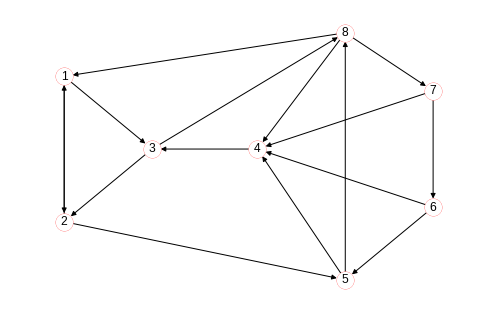

In [332]:
G = nx.DiGraph() # directed

# Graph 2
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 1)
G.add_edge(2, 5)
G.add_edge(3, 2)
G.add_edge(3, 8)
G.add_edge(4, 3)
G.add_edge(5, 4)
G.add_edge(5, 8)
G.add_edge(6, 4)
G.add_edge(6, 5)
G.add_edge(7, 6)
G.add_edge(7, 4)
G.add_edge(8, 7)
G.add_edge(8, 4)
G.add_edge(8, 1)
fixed_positions = {1:(1,8), 2:(1,3), 3:(3.5,5.5), 4:(6.5,5.5),
                   5:(9,1), 6:(11.5,3.5), 7:(11.5,7.5), 8:(9,9.5)}


fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

# show G
nx.draw_networkx_nodes(G,pos)
nx.draw(G, pos, with_labels=True, node_color='white')

**PageRank Implementation**

*Example 1: Computing the Google matrix*

* the google matrix can be defined as a :<br> *transition matrix of the Markov chain of a random progression through web pages* <br>(random because web surfers don't uniformely pick one of the links).
* computing the google matrix is the key first step to compute page ranks. 
* In this example we just make sure that this step is implemented correctly.
* example taken from [Wikiversity](https://en.wikiversity.org/wiki/Google/Matrix).
* Googel Matrix formula:
  $$Google\ Matrix  = \theta B + \frac{1-\theta}{N} \ (\vec{1} \cdot \vec{1}.T)$$
  where 
  * *B* is the transition matrix of the input graph G
  * $\theta$ is the parameter used to introduce a *random progression* element to the transition matrix *B* 
  * $\vec{1}$ is a vector of ones
  
* About *random progression*:

  * When computing PageRanks one must keep in mind that web surfers are at the core of these rankings.
  * Hence it is not sufficient to solely consider the link structure of the web and its corresponding transitions probability matrix derived from that link structure. 
  
  * Indeed, supposing that a websurfer is on some webpage and has a number N of possible links to select from as a next destination, web surfers do not always pick this destination link with a 1/N probability uniformely distributed over all available links. 
  
  * Therefore, the transition matrix $B$ is augmented by adding to each element $B_{ij}$ some random quantity. Ther magnitude if this quantity  is determined by the value of $\theta$.
  
  * A commonly used value for  $\theta$ is 0.85 which is considered a erasonable tradeoff between the linbk structure of the graph and the random/unpredictable side of human behavior.

In [333]:
# Initialize some useful values
theta = 0.85
N = 3

# Initialize a rank 1 vector of ones
# will be used to produce an NxN matrix of ones by multiplying the vector of ones (Nx1) with its transpose (1xN)
ones = np.ones((N,), dtype=int) # row vector
ones.shape = (N,1) # force it to be a column vector
# print(ones * ones.T) 

# Transition matrix B of A
A = np.matrix([[0, 1, 1], [1, 0, 0], [0, 1, 0]])
print('\nAdjaceny matrix A:\n\n', A)
L, D = scipy.sparse.csgraph.laplacian(csgraph=A, return_diag=True, use_out_degree=True) # important to specify the use of out degree!! 
degree_matrix = np.diag(D) # np.diag is needed to turn the degree array returned by scipy into a matrix
D_inv = np.linalg.inv(degree_matrix)
B = D_inv * A
print('\nTransition probability matrix B of A at time t=0:\n\n', B)

# Google Matrix C
C = (theta * B) + ((1-theta) / N * (ones * ones.T))
print('\nGoogle Matrix:\n\n', C)
print('\n this result matches the result shown in the source example.')


Adjaceny matrix A:

 [[0 1 1]
 [1 0 0]
 [0 1 0]]

Transition probability matrix B of A at time t=0:

 [[ 0.0000  0.5000  0.5000]
 [ 1.0000  0.0000  0.0000]
 [ 0.0000  1.0000  0.0000]]

Google Matrix:

 [[ 0.0500  0.4750  0.4750]
 [ 0.9000  0.0500  0.0500]
 [ 0.0500  0.9000  0.0500]]

 this result matches the result shown in the source example.


<br>*Example 2: Computing Pagrank from the Googel Matrix*

* In this example we first compute the Google matrix, then we apply the iterations to update the PageRank vector until it converges to a * to fixed, steady-state quantity*.
* example is based on the algorithm presented in [Networks: Friends, Money, and Bytes!](https://www.coursera.org/learn/friends-money-bytes/home/week/2) (Week 2 Lesson 2).

* Steps:

  1. Compute adjaceny matrix $H$ from $G$.
  2. Deal with dangling nodes in $H$.
  3. Compute transition probability matrix $B$ from $H$.
  4. Compute Google Matrix $C$ by incorporating randomization into $B$.
  5. Compute the PageRank vector $\vec{p}$:
       * Initialize PageRank vector elements to 1/N
       * Iterate over the PageRank vector as follows:
  
  $$\vec{p}[k+1] = \vec{p}[k] \cdot C$$
  

*Step 1: Compute adjaceny matrix $H$ from $G$.*

In [0]:
# Initialize some useful values
theta = 0.85
out_degree_dict = dict(G.out_degree()) # needed for option 1
N = nx.number_of_nodes(G)
# print(type(out_degree_dict))
# print(N)

# Initialize create a rank 1 vector of ones
ones = np.ones((N,), dtype=int) # row vector
ones.shape = (N,1) # force it to be a column vector
# print(ones)

In [335]:
# Get the Adjacency matrix H
H = nx.to_scipy_sparse_matrix(G, nodelist=[1,2,3,4,5,6,7,8])
H = H.todense()
print('\nAdjacency Matrix H of G:\n', H)


Adjacency Matrix H of G:
 [[0 1 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [1 0 0 1 0 0 1 0]]


*Step 2: Deal with dangling nodes in $H$.*

  * In the adjacency matrix, dangling nodes translate to rows with all zeros. If left unchanged this will cuases issues in the PageRank calculation (see lecure for more details).
  * In order to deal with dangling nodes we augment $H$ by adding a matrix to $H$ such that there are no rows with all zeros. Specifically, the row of zeros for dangling nodes are replaced by 1/N. The row then adds up to 1. This is referred to as **mandatory score spreading**. 
  
  * Dangling nodes formula: $\hat{H} = H + \frac{1}{N} \cdot w \cdot \vec{1}.T$
  
    where 
    
    * $w$ is a binary `Nx1` vector to indicate which nodes are dangling
    
    * $\vec{1}$ is a vector of ones
  
  

In [336]:
# Get Nodes that have no outlink
dangling_nodes = []
[dangling_nodes.append(node) for node, out_degree in out_degree_dict.items() if out_degree == 0]
print('\nDangling Nodes:', dangling_nodes)


# Construct vector to indicate which nodes are dangling
w = np.zeros((N,1), dtype=int) # column vector
for i in dangling_nodes:
  w[i] = 1
# print(w)

# create matrix that will be added to H to deal with dandgling nodes
score_spreading_matrix = 1/N * w * ones.T # outer product 
# print('\nArtifical matrix \n(will be added to H to deal with dandgling nodes)\n', score_spreading_matrix)

# add artificial matrix to H
HHat = H + score_spreading_matrix
print('\nH before score spreading:\n\n', H)
print('\nH after score spreading:\n\n', HHat)


Dangling Nodes: []

H before score spreading:

 [[0 1 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1]
 [0 0 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [1 0 0 1 0 0 1 0]]

H after score spreading:

 [[ 0.0000  1.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
 [ 1.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000]
 [ 0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000]
 [ 0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  1.0000]
 [ 0.0000  0.0000  0.0000  1.0000  1.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  1.0000  0.0000  1.0000  0.0000  0.0000]
 [ 1.0000  0.0000  0.0000  1.0000  0.0000  0.0000  1.0000  0.0000]]


*Step 3: Compute the transition probability matrix (at time t=0) matrix $B$ from $H$*.

* Option 1: $B$ is a normalized, out-degree weighted, adjacency matrix of $G$ <br>i.e. if a $H_{ij}$ edge exists, then we divide 1 by the row total (number of outgoing links of node *i*).
  
* Option 2: $B$ is computed using the equation $B =D^{-1} H$ .  

In [337]:
# Option 1: Normalize H
# B = H / H.sum(axis=1) # divide row element wise by the sum of the row
# print('\nTransition probability matrix:\n\n', H)

# Option 2: use equation P = Dinv * H
L, D = scipy.sparse.csgraph.laplacian(csgraph=H, return_diag=True, use_out_degree=True) # important to specify the use of out degree!! 
degree_matrix = np.diag(D) # np.diag is needed to turn the degree array returned by scipy into a matrix
D_inv = np.linalg.inv(degree_matrix)
B = D_inv * H
print('\nTransition probability matrix:\n\n', B)  


Transition probability matrix:

 [[ 0.0000  0.5000  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000]
 [ 0.5000  0.0000  0.0000  0.0000  0.5000  0.0000  0.0000  0.0000]
 [ 0.0000  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000  0.5000]
 [ 0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.5000  0.0000  0.0000  0.0000  0.5000]
 [ 0.0000  0.0000  0.0000  0.5000  0.5000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.5000  0.0000  0.5000  0.0000  0.0000]
 [ 0.3333  0.0000  0.0000  0.3333  0.0000  0.0000  0.3333  0.0000]]


*Step 4: Compute Google Matrix $C$ by incorporating randomization into $B$.*

In [338]:
C = (theta * B) + ((1-theta) / N * (ones * ones.T))
print('\nGoogle matrix C:\n\n', C)


Google matrix C:

 [[ 0.0188  0.4437  0.4437  0.0188  0.0188  0.0188  0.0188  0.0188]
 [ 0.4437  0.0188  0.0188  0.0188  0.4437  0.0188  0.0188  0.0188]
 [ 0.0188  0.4437  0.0188  0.0188  0.0188  0.0188  0.0188  0.4437]
 [ 0.0188  0.0188  0.8688  0.0188  0.0188  0.0188  0.0188  0.0188]
 [ 0.0188  0.0188  0.0188  0.4437  0.0188  0.0188  0.0188  0.4437]
 [ 0.0188  0.0188  0.0188  0.4437  0.4437  0.0188  0.0188  0.0188]
 [ 0.0188  0.0188  0.0188  0.4437  0.0188  0.4437  0.0188  0.0188]
 [ 0.3021  0.0188  0.0188  0.3021  0.0188  0.0188  0.3021  0.0188]]


*Step 5: Compute the PageRank vector $\vec{p}$*

In [339]:
# Initialize PageRank vector
p = np.ones((N,), dtype=int) # row vector
p = p / N
p.shape = (N,1) # force it to be a column vector
# print(pagerank)

# Iterate
for i in range(10):
  p_new = p.T * C # pagerank_new is T
  
  if i in [0,5]:
    print('\nPageRank vector @ iteration', i+1, '\n', p_new)
  
  p = pagerank_new.T # un-transpose it for next iteration
  
print('\nFinal PageRank vector:\n', p.T) # out of curiosity
print('\nRanked nodes as shown in source example: 3,2,4,8,1,5,7,6')
print('\nThe results match the result shown in the source example!\n')

# get index of highest ranked node
index, value = max(enumerate(p.tolist()), key=operator.itemgetter(1))
pos = index+1
print('Node %i has highest score.\n' %pos) # list is indexed at zero
print("The intuition behind the results is that node 4 gives away all its importance scores to node 3. "\
      "\nNode 3 does not give it back to 4, instead spreads it further to 2 and 8." \
      "\nThus, as per PageRank's modelling of user behaviour, node 3 is considered the most important node in the graph.")




PageRank vector @ iteration 1 
 [[ 0.1073  0.1250  0.1781  0.2135  0.1250  0.0719  0.0542  0.1250]]

PageRank vector @ iteration 6 
 [[ 0.1286  0.1590  0.2015  0.1507  0.1053  0.0447  0.0610  0.1491]]

Final PageRank vector:
 [[ 0.1287  0.1590  0.2013  0.1507  0.1055  0.0446  0.0610  0.1492]]

Ranked nodes as shown in source example: 3,2,4,8,1,5,7,6

The results match the result shown in the source example!

Node 3 has highest score.

The intuition behind the results is that node 4 gives away all its importance scores to node 3. 
Node 3 does not give it back to 4, instead spreads it further to 2 and 8.
Thus, as per PageRank's modelling of user behaviour, node 3 is considered the most important node in the graph.


**Compare with result returned fron an networkx function**

In [340]:
# %time pr = nx.pagerank(G)
pr = nx.pagerank(G)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1),reverse=True)
print('\nSorted Pageranks:\n')
[print(i) for i in sorted_pr]

pr_max = max(pr.items(), key= lambda x: x[1])
print('\nElement with the highest PageRank: {0}'.format(pr_max[0]))


Sorted Pageranks:

(3, 0.2014952664827191)
(2, 0.15904062780177625)
(4, 0.15069281099475343)
(8, 0.14915025076172478)
(1, 0.12860168411687445)
(5, 0.10533077655471167)
(7, 0.061009431349396445)
(6, 0.04467915193804382)

Element with the highest PageRank: 3
